# Information Bottleneck

### 1. Motivation

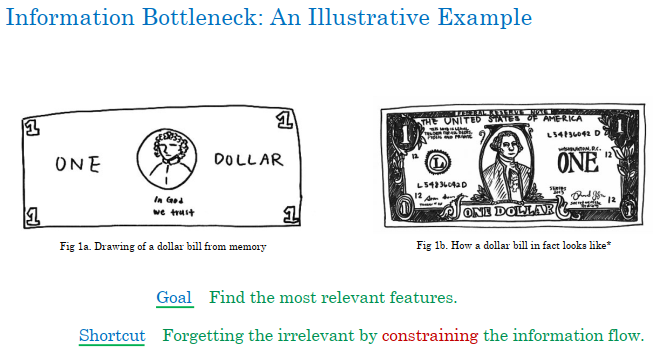

### 2. The Mutual Information Perspective for DNN

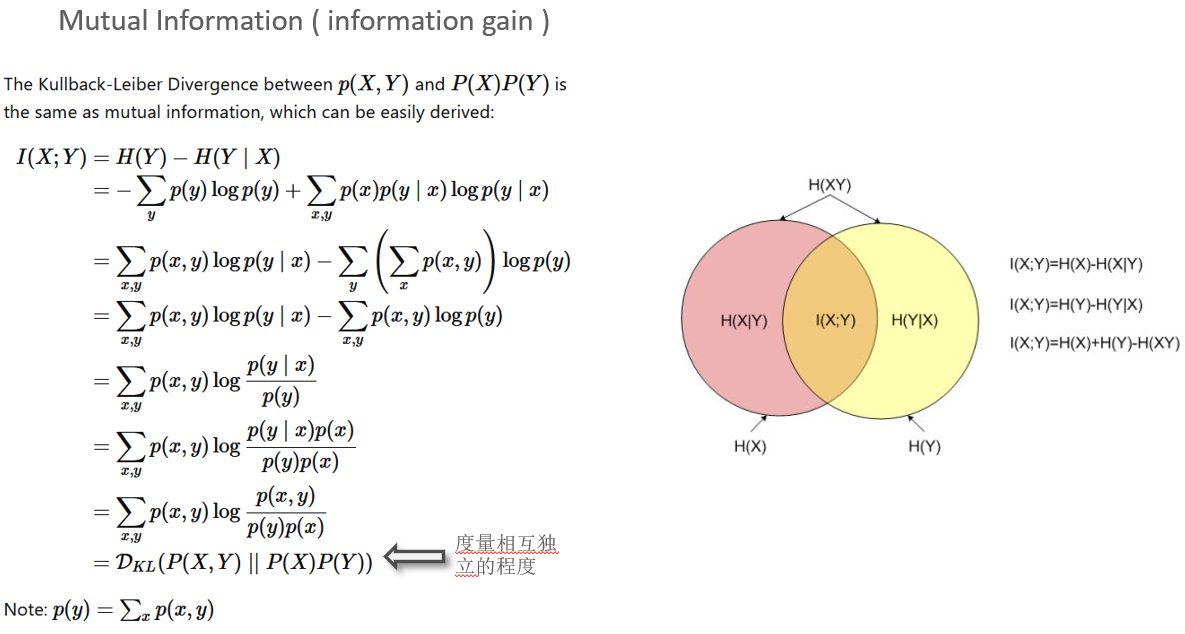

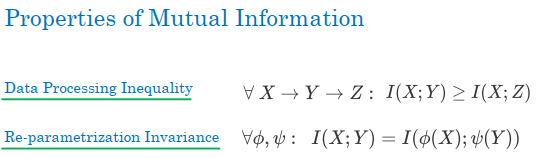

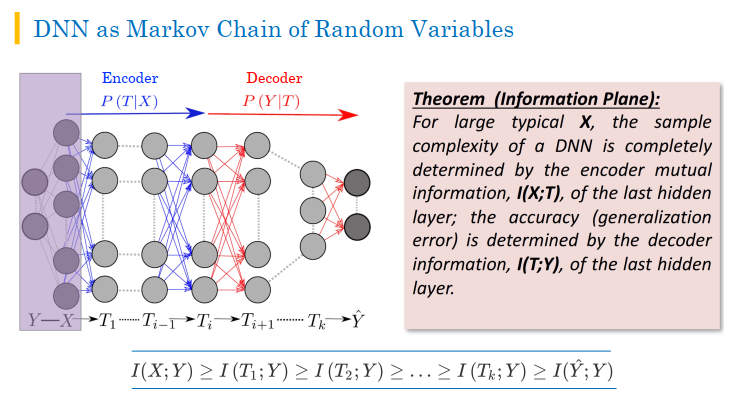

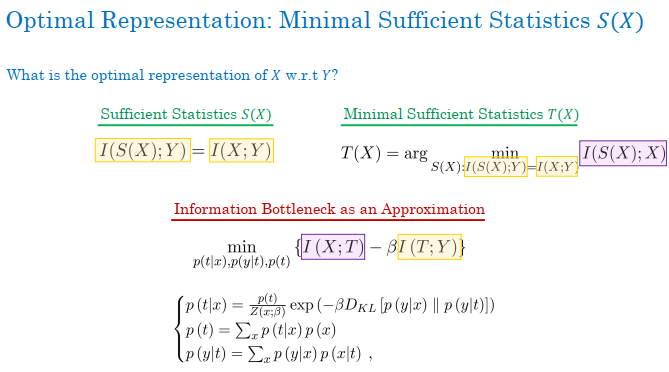

### 3. Variational Information Bottleneck (VIB)  -  Information Bottleneck as a Regularizer for DNN

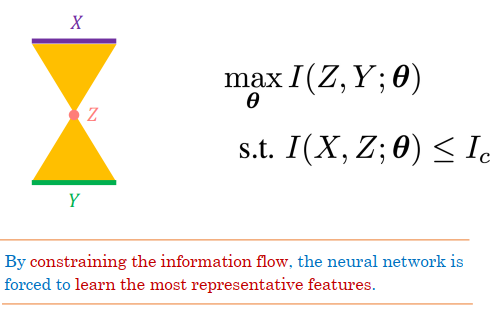

### 4. VAE as a special case of VIB

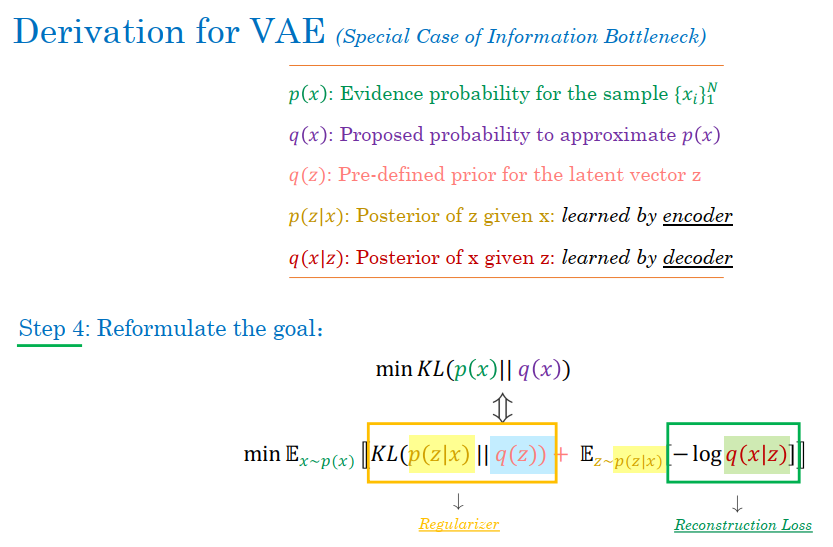

Reference: https://github.com/ZIYU-DEEP/Awesome-Information-Bottleneck

#### β-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework. ICLR 2017.

" We introduce an adjustable hyperparameter beta that balances latent channel capacity and independence constraints with reconstruction accuracy.  We demonstrate that beta-VAE with appropriately tuned beta > 1 qualitatively outperforms VAE (beta = 1) ".   
beta-VAE : VIB. beta = 1 is the original VAE.

In [19]:
# Implementation: https://github.com/viniciusguigo/pytorch_dvib

"""dvib.py

PyTorch implementation of the Deep Variational Information Bottleneck (DVIB)
based on the "Deep Variational Information Bottleneck" paper by Alexander A. 
Alemi, Ian Fischer, Joshua V. Dillon, Kevin Murphy, and their original release
in Tensorflow (https://github.com/alexalemi/vib_demo).
"""
import math, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.distributions.normal import Normal

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

class EncoderDVIB(nn.Module):
    """Encoder for the Deep Variational Information Bottleneck (DVIB).
    """
    def __init__(self, input_size, latent_dim, out_size1=1024,
                 out_size2=1024):        
        super(EncoderDVIB, self).__init__()
        # encoder network
        self.linear1 = nn.Linear(input_size, out_size1)
        self.linear2 = nn.Linear(out_size1, out_size2)
        self.encoder_mean = nn.Linear(out_size2, latent_dim)
        self.encoder_std = nn.Linear(out_size2, latent_dim)

        # network initialization
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.encoder_mean.weight)
        nn.init.xavier_uniform_(self.encoder_std.weight)

    def forward(self, x): # 一个典型的VAE的encoder
        # forward pass through encoder
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        encoder_mean = self.encoder_mean(x)
        encoder_std = F.softplus(self.encoder_std(x))

        # sample latent based on encoder outputs
        latent_dist = Normal(encoder_mean, encoder_std)
        latent = latent_dist.sample() # z

        return latent, encoder_mean, encoder_std


class DecoderDVIB(nn.Module):
    """Decoder for the Deep Variational Information Bottleneck (DVIB).
    """
    def __init__(self, latent_dim, output_size, classif_loss):        
        super(DecoderDVIB, self).__init__()
        self.classif_loss = classif_loss
        # decoder network
        self.linear1 = nn.Linear(latent_dim, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

        # network initialization
        nn.init.xavier_uniform_(self.linear1.weight)

    def forward(self, x):
        if self.classif_loss:
            # using classification loss on decoder, return softmax values
            return self.log_softmax(self.linear1(x))
        else:  # 一个典型的VAE的decoder
            # standard reconstruction loss
            return self.linear1(x)    


class DVIB(nn.Module):
    """Deep Variational Information Bottleneck (DVIB).

    Arguments:
        input_size: size of input data
        latent_dim: dimension of encoder mean and std
        output_size: size of the output data
    """
    def __init__(self, input_size, latent_dim, output_size,
                       classif_loss=False):        
        super(DVIB, self).__init__()
        # store DVIB hyperparamenters
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.output_size = output_size
        self.beta = 1e-3
        self.prior = Normal(torch.zeros(1,latent_dim),torch.ones(1,latent_dim))
        self.classif_loss = classif_loss
        
        # initialize encoder and decoder
        self.encoder = EncoderDVIB(input_size, latent_dim)
        self.decoder = DecoderDVIB(latent_dim, output_size, classif_loss)

        ## loss function
        # prediction component
        if classif_loss:
            # binary classification (cross entropy loss)
            self.pred_loss = nn.NLLLoss(reduction='mean')
        else:
            # standard reconstruction loss (MSE between input and outputs)
            self.pred_loss = nn.MSELoss(reduction='mean')
        # regularization component computed in self.compute_loss()

    def forward(self, x):
        # pass input through encoder
        latent, latent_mean, latent_std = self.encoder(x)
                
        # pass latent through decoder
        output = self.decoder(latent)

        return output, latent, latent_mean, latent_std

    def compute_loss(self, input_data, output_data, output_latent,
                        enc_mean=None, enc_std=None):
        """Compute DVIB loss for a pair of input and output."""
        # compute KL between encoder output and prior using pytorch dists
        enc_dist = Normal(enc_mean.detach(), enc_std.detach())
        kl_vec = torch.distributions.kl.kl_divergence(enc_dist, self.prior)  #  self.prior - 标准正态分布
        kl_loss = kl_vec.mean()

        # compute loss
        pred = self.pred_loss(input_data, output_data)
        loss = pred + self.beta*kl_loss # 重建误差 + KLD正则化. beta = 1 equals original VAE.

        return loss, pred, kl_loss

    def test_mnist(self, vis_train_data=False):
        """Tests DVIB on the MNIST dataset.
        """
        # optimizer
        optimizer = optim.Adam(dvib.parameters())    

        # train data (MNIST)
        train_data = datasets.MNIST('../data/', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
        batch_size = 1024
        n_samples_train = train_data.data.shape[0]
        train_dataloader = torch.utils.data.DataLoader(
            train_data, batch_size=batch_size, shuffle=True)
        train_dataiter = iter(train_dataloader)

        # visualize training data
        if vis_train_data:
            # sample images and labels from dataloader
            images, labels = next(train_dataiter)

            # display a sample of them
            plt.figure()
            plt.suptitle('Batch Sampled from MNIST Dataset')
            grid_size = math.ceil(math.sqrt(batch_size))
            for index in range(batch_size):
                plt.subplot(grid_size, grid_size, index+1)
                plt.axis('off')
                plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
            plt.show()

        # train
        epochs = 1000
        loss_vals = []
        pred_loss_vals = []
        kl_loss_vals = []
        for epoch in range(epochs):
            # sample train data
            try:
                input_data, labels = next(train_dataiter)
            except StopIteration:
                train_dataiter = iter(train_dataloader)
                input_data, labels = next(train_dataiter)
            # reshape to match DVIB
            n_sampled = input_data.shape[0]
            input_data = input_data.view(n_sampled, 28*28)

            # update model
            loss_val, pred_loss_val, kl_loss_val = train(
                                            epoch, dvib, optimizer, input_data)
            loss_vals.append(loss_val)
            pred_loss_vals.append(pred_loss_val)
            kl_loss_vals.append(kl_loss_val)

        # test dataloader
        test_data = datasets.MNIST('../data/', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
        batch_size = 5
        test_dataloader = torch.utils.data.DataLoader(
            test_data, batch_size=batch_size, shuffle=True)
        test_dataiter = iter(test_dataloader)

        # sample test data
        input_data, labels = next(test_dataiter)
        n_sampled = input_data.shape[0]
        input_data = input_data.view(n_sampled, 28*28)
        
        # predict outputs
        dvib.eval()
        output_data, output_latent, latent_mean, latent_std = dvib(input_data)
        output_data = output_data.detach()

        # # plot results
        # # visual predictions
        input_data = input_data.view(n_sampled, 28, 28)
        output_data = output_data.view(n_sampled, 28, 28)
        plt.figure()
        plt.suptitle('DVIB MNIST Example: Input (top) vs Predicted (bottom)')
        for index in range(batch_size):
            # plot ground truth
            plt.subplot(2, batch_size, index+1)
            plt.axis('off')
            plt.imshow(input_data[index], cmap='gray_r')
            # plot prediction
            plt.subplot(2, batch_size, index+batch_size+1)
            plt.axis('off')
            plt.imshow(output_data[index], cmap='gray_r')

        # loss
        plt.figure()
        plt.title('DVIB Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss Value')
        x_epochs = torch.arange(0, epochs)
        smooth_int = 20
        plt.plot(x_epochs[::smooth_int], loss_vals[::smooth_int],
                    '-', label='Total Loss')
        plt.plot(x_epochs[::smooth_int], pred_loss_vals[::smooth_int],
                    '--', label='Pred Loss')
        plt.plot(x_epochs[::smooth_int], kl_loss_vals[::smooth_int],
                    '--', label='KL Loss (mean, unscaled)')
        plt.legend()
        plt.grid()

        # visualize latent space over multiple predictions
        if self.latent_dim == 2:
            import numpy as np
            fig, ax = plt.subplots()
            plt.title('2D Encoder Mean for each MNIST class (when K=2)')
            colors = ['bo','ro','go','yo','mo','b*','r*','g*','y*','m*']
            labels = ['0','1','2','3','4','5','6','7','8','9']

            for i in range(10):
                n_samples_latent = 20
                ## generate input data for class and its predictions
                # select only images from the desired class (number == i)
                idxs_label = test_data.targets == i
                idxs_numbers = [k for k, val in enumerate(idxs_label) if val]

                # create random sampler and dataloader for specific class
                test_sampler = torch.utils.data.sampler.SubsetRandomSampler(
                                                                idxs_numbers)
                test_sampler_loader = iter(torch.utils.data.DataLoader(
                                            test_data,
                                            batch_size=1, 
                                            sampler=test_sampler))

                for j in range(n_samples_latent):
                    # select a random image from the desired class
                    input_data, _ = next(test_sampler_loader)
                    input_data = input_data.view(1, 28*28)

                    # # visualize selected class
                    # plt.imshow(input_data.view(28, 28), cmap='gray_r')
                    # plt.show()
                    
                    # predict output
                    output_data, output_latent, latent_mean, latent_std = dvib(
                                                                    input_data)

                    # plot latent variables
                    latent_mean = latent_mean.detach().numpy().squeeze()
                    if j == 0:  # add label
                        plt.plot(latent_mean[0], latent_mean[1], colors[i],
                                                    alpha=0.5, label=labels[i])
                    else:
                        plt.plot(latent_mean[0], latent_mean[1], colors[i],
                                                    alpha=0.5)
            plt.grid()
            plt.legend()

        plt.show()

    def test_mnist_classification(self, vis_train_data=False, plot_tsne=False):
        """Tests DVIB on the MNIST dataset using classification loss instead
        of a reconstruction loss.
        """
        # optimizer
        optimizer = optim.Adam(dvib.parameters())    

        # train data (MNIST)
        train_data = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
        n_samples_train = train_data.data.shape[0]
        batch_size = 256 # n_samples_train
        train_dataloader = torch.utils.data.DataLoader(
            train_data, batch_size=batch_size, shuffle=True)
        train_dataiter = iter(train_dataloader)

        # visualize training data
        if vis_train_data:
            # sample images and labels from dataloader
            images, labels = next(train_dataiter)

            # display a sample of them
            plt.figure()
            plt.suptitle('Batch Sampled from MNIST Dataset')
            grid_size = math.ceil(math.sqrt(batch_size))
            for index in range(batch_size):
                plt.subplot(grid_size, grid_size, index+1)
                plt.axis('off')
                plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
            plt.show()

        # train
        epochs = 2500
        loss_vals = []
        pred_loss_vals = []
        kl_loss_vals = []
        for epoch in range(epochs):
            # sample train data
            try:
                input_data, labels = next(train_dataiter)
            except StopIteration:
                train_dataiter = iter(train_dataloader)
                input_data, labels = next(train_dataiter)
            # reshape to match DVIB
            n_sampled = input_data.shape[0]
            input_data = input_data.view(n_sampled, 28*28).to(device)
            labels = labels.to(device)

            # update model
            loss_val, pred_loss_val, kl_loss_val = train(
                        epoch, dvib, optimizer, input_data, label_data=labels)
            loss_vals.append(loss_val)
            pred_loss_vals.append(pred_loss_val)
            kl_loss_vals.append(kl_loss_val)

        # test dataloader
        test_data = datasets.MNIST('../data/', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
        batch_size = 25
        test_dataloader = torch.utils.data.DataLoader(
            test_data, batch_size=batch_size, shuffle=True)
        test_dataiter = iter(test_dataloader)

        # sample test data
        input_data, labels = next(test_dataiter)
        n_sampled = input_data.shape[0]
        input_data = input_data.view(n_sampled, 28*28).to(device)
        
        # predict outputs
        dvib.eval()
        output_data, output_latent, latent_mean, latent_std = dvib(input_data)
        output_data = output_data
        output_labels = torch.argmax(output_data, axis=1).detach()

        # # plot results
        # # visual predictions
        input_data = input_data.view(n_sampled, 28, 28)
        plt.figure()
        plt.suptitle('DVIB MNIST Example: Input (top) vs Predicted (bottom)')
        for index in range(batch_size):
            # plot ground truth
            ax = plt.subplot(5, 5, index+1)
            ax.text(0.5,-0.1, f'Pred: {output_labels[index].item()}',
                    size=12, ha="center", transform=ax.transAxes)
            plt.axis('off')
            plt.imshow(input_data[index], cmap='gray_r')

        # loss
        plt.figure()
        plt.title('DVIB Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss Value')
        x_epochs = torch.arange(0, epochs)
        smooth_int = 10
        plt.plot(x_epochs[::smooth_int], loss_vals[::smooth_int],
                                        '-', label='Total Loss')
        plt.plot(x_epochs[::smooth_int], pred_loss_vals[::smooth_int],
                                        '--', label='Pred Loss')
        plt.plot(x_epochs[::smooth_int], kl_loss_vals[::smooth_int],
                                        '--', label='KL Loss (mean, unscaled)')
        plt.legend()
        plt.grid()

        # visualize latent space over multiple predictions
        if self.latent_dim == 2:
            import numpy as np
            fig, ax = plt.subplots()
            plt.title('2D Encoder Mean for each MNIST class (when K=2)')
            colors = ['bo','ro','go','yo','mo','b*','r*','g*','y*','m*']
            labels = ['0','1','2','3','4','5','6','7','8','9']

            for i in range(10):
                n_samples_latent = 20
                ## generate input data for class and its predictions
                # select only images from the desired class (number == i)
                idxs_label = test_data.targets == i
                idxs_numbers = [k for k, val in enumerate(idxs_label) if val]

                # create random sampler and dataloader for specific class
                test_sampler = torch.utils.data.sampler.SubsetRandomSampler(
                                                                idxs_numbers)
                test_sampler_loader = iter(torch.utils.data.DataLoader(
                                            test_data,
                                            batch_size=1, 
                                            sampler=test_sampler))

                for j in range(n_samples_latent):
                    # select a random image from the desired class
                    input_data, _ = next(test_sampler_loader)
                    input_data = input_data.view(1, 28*28)

                    # # visualize selected class
                    # plt.imshow(input_data.view(28, 28), cmap='gray_r')
                    # plt.show()
                    
                    # predict output
                    output_data, output_latent, latent_mean, latent_std = dvib(
                                                                    input_data)

                    # plot latent variables
                    latent_mean = latent_mean.detach().numpy().squeeze()
                    if j == 0:  # add label
                        plt.plot(latent_mean[0], latent_mean[1], colors[i],
                                                alpha=0.5, label=labels[i])
                    else:
                        plt.plot(latent_mean[0], latent_mean[1], colors[i],
                                                alpha=0.5)
            plt.grid()
            plt.legend()

        # visualize t-sne plot
        if plot_tsne:
            from MulticoreTSNE import MulticoreTSNE as TSNE
            print('Generating t-SNE plot...')

            # re-loading test data
            test_data = datasets.MNIST('../data/', train=False, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
            batch_size = 10000
            test_dataloader = torch.utils.data.DataLoader(
                test_data, batch_size=batch_size, shuffle=True)
            test_dataiter = iter(test_dataloader)
            input_data, labels = next(test_dataiter)
            n_sampled = input_data.shape[0]
            input_data = input_data.view(n_sampled, 28*28) 

            # generating new predictions with trained model
            output_data, output_latent, latent_mean, latent_std = dvib(
                                                                    input_data)

            # generate t-sne data
            embeddings = TSNE(n_jobs=4).fit_transform(
                                                latent_mean.detach().numpy())

            # plot it
            vis_x = embeddings[:, 0]
            vis_y = embeddings[:, 1]
            plt.figure()
            plt.title('DVIB Latent Mean via t-SNE')
            plt.scatter(
                vis_x, vis_y,
                c=labels, cmap=plt.cm.get_cmap("jet", 10), marker='.')
            plt.colorbar(ticks=range(10))
            plt.clim(-0.5, 9.5)
            plt.show()


        plt.show()    

In [12]:

def train(epoch, model, optimizer, input_data, label_data=None):
    
    # forward pass
    if model.classif_loss:
        # using DVIB for classification and not reconstruction
        output_data, output_latent, latent_mean, latent_std = model(input_data)

        # compute loss
        loss, pred, kl_loss = model.compute_loss(
            output_data, label_data, output_latent, latent_mean, latent_std)

    else:
        # standard reconstruction
        output_data, output_latent, latent_mean, latent_std = model(input_data)

        # compute loss
        loss, pred, kl_loss = model.compute_loss(
            input_data, output_data, output_latent, latent_mean, latent_std)

    # backpropagate and update optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print statistics
    if epoch % 100 == 0:
        print(f'Epoch {epoch:.4f} | Loss {loss.item():.4f} | ' + \
            f'Pred Loss {pred.item():.4f} | KL Loss: {kl_loss.item():.4f}')

    return loss.item(), pred.item(), kl_loss.item()

In [13]:
# tests DVIB on MNIST dataset (classification loss)
input_size = 28*28
latent_dim = 512  # K variable (paper)
output_size = 10  # number of classes (10 digits)

device = 'cpu' # torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

dvib = DVIB(input_size, latent_dim, output_size, classif_loss=True).to(device)
print(dvib)

# from torchview import draw_graph
# model_graph = draw_graph(dvib, input_size=(1, input_size), expand_nested=True) # device='meta', 
# model_graph.visual_graph

device:  cpu
DVIB(
  (encoder): EncoderDVIB(
    (linear1): Linear(in_features=784, out_features=1024, bias=True)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (encoder_mean): Linear(in_features=1024, out_features=512, bias=True)
    (encoder_std): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): DecoderDVIB(
    (linear1): Linear(in_features=512, out_features=10, bias=True)
    (log_softmax): LogSoftmax(dim=1)
  )
  (pred_loss): NLLLoss()
)


Epoch 0.0000 | Loss 2.9304 | Pred Loss 2.9304 | KL Loss: 0.3256
Epoch 100.0000 | Loss 1.1543 | Pred Loss 1.1543 | KL Loss: 0.3213
Epoch 200.0000 | Loss 0.8548 | Pred Loss 0.8547 | KL Loss: 0.3254
Epoch 300.0000 | Loss 0.8393 | Pred Loss 0.8393 | KL Loss: 0.3332
Epoch 400.0000 | Loss 0.7469 | Pred Loss 0.7469 | KL Loss: 0.3342
Epoch 500.0000 | Loss 0.7156 | Pred Loss 0.7155 | KL Loss: 0.3261
Epoch 600.0000 | Loss 0.8387 | Pred Loss 0.8386 | KL Loss: 0.3318
Epoch 700.0000 | Loss 0.6834 | Pred Loss 0.6834 | KL Loss: 0.3330
Epoch 800.0000 | Loss 0.6895 | Pred Loss 0.6894 | KL Loss: 0.3267
Epoch 900.0000 | Loss 0.7598 | Pred Loss 0.7598 | KL Loss: 0.3364
Epoch 1000.0000 | Loss 0.5958 | Pred Loss 0.5958 | KL Loss: 0.3348
Epoch 1100.0000 | Loss 0.6555 | Pred Loss 0.6555 | KL Loss: 0.3319
Epoch 1200.0000 | Loss 0.6790 | Pred Loss 0.6790 | KL Loss: 0.3316
Epoch 1300.0000 | Loss 0.6854 | Pred Loss 0.6854 | KL Loss: 0.3330
Epoch 1400.0000 | Loss 0.6508 | Pred Loss 0.6508 | KL Loss: 0.3274
Epoch 1

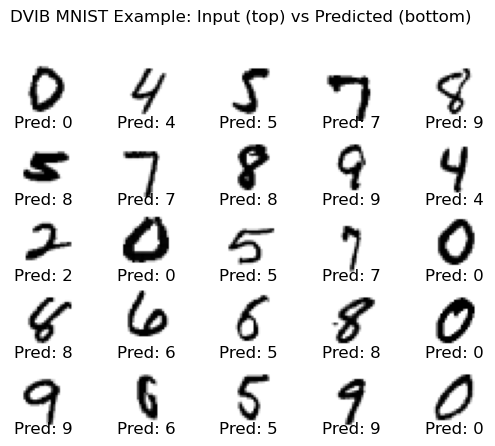

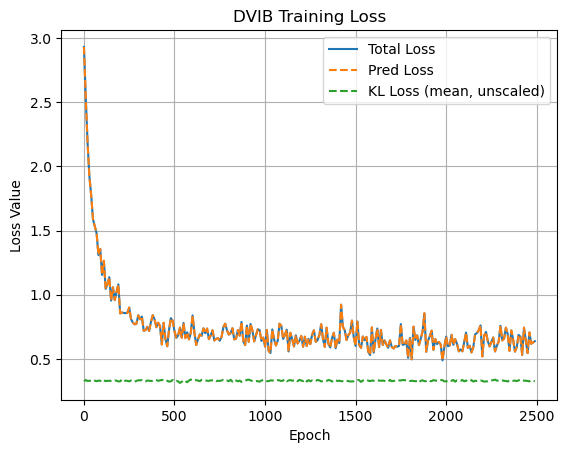

In [14]:
dvib.beta = 1e-4
dvib.test_mnist_classification()

#### "Spatial attention for human-centric visual understanding: An Information Bottleneck method", https://doi.org/10.1016/j.cviu.2024.104180:

"The selective visual attention mechanism in the Human Visual System (HVS) restricts the amount of
information that reaches human visual awareness, allowing the brain to perceive high-fidelity natural scenes
in real-time with limited computational cost. This selectivity acts as an __‘‘Information Bottleneck (IB)’’ that
balances information compression and predictive accuracy__. However, such information constraints are rarely
explored in the attention mechanism for deep neural networks (DNNs). This paper introduces __an IB-inspired
spatial attention module for DNNs__, which generates __an attention map by minimizing the mutual information
(MI) between the attentive content and the input while maximizing that between the attentive content and the
output.__ "

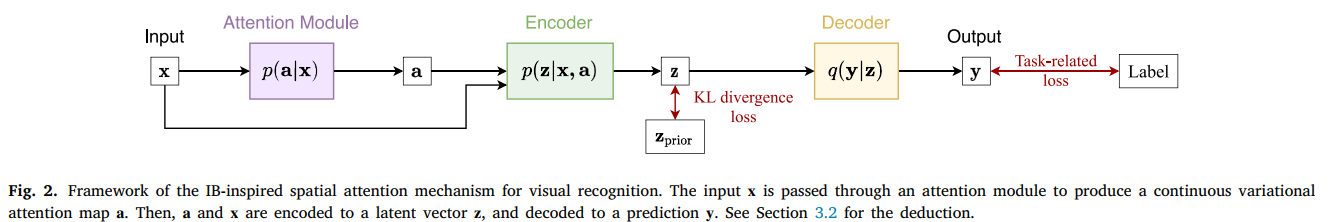 Compare to VAE